In [1]:
!pip install kaggle
!pip -qq install xgboost
!pip -qq install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)


In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute  import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder as OrdinalEncoder_Sk
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer

from feature_engine.encoding import RareLabelEncoder,OrdinalEncoder
from feature_engine.selection import DropFeatures

# to visualise all the columns and upto 100 rows in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

# for supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from IPython.display import display

# Membaca dataset
train_data = pd.read_csv('/content/sample_data/train.csv')
test_data = pd.read_csv('/content/sample_data/test.csv')
sample_submission_data = pd.read_csv('/content/sample_data/sample_submission.csv')

# Menampilkan bentuk (shape) dari masing-masing dataset
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("Sample Submission Data Shape:", sample_submission_data.shape)

# Menampilkan beberapa baris pertama dari masing-masing dataset dalam bentuk tabel
print("\nTrain Data Head:")
display(train_data.head())

print("\nTest Data Head:")
display(test_data.head())

print("\nSample Submission Data Head:")
display(sample_submission_data.head())


Train Data Shape: (1460, 81)
Test Data Shape: (1459, 80)
Sample Submission Data Shape: (1459, 2)

Train Data Head:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Test Data Head:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal



Sample Submission Data Head:


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [5]:
# Replace 'data' with either 'train_data' or 'test_data',
# depending on which dataset's information you want to view.

# To view train data information:
train_data.info()

# To view test data information:
# test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [75]:
df_num = train_data.select_dtypes(include=['number'])
corr = df_num.corr()
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

In [6]:
import pandas as pd
from IPython.display import display

# Assuming you want to analyze the train data,
# replace 'train_data' with 'test_data' if you want to analyze the test data instead.
data = train_data

summary = pd.DataFrame(data.dtypes, columns=['dtype'])
summary = summary.reset_index()
summary = summary.rename(columns={'index':'Name'})
summary['Null_Counts'] = data.isnull().sum().values
summary['Uniques'] = data.nunique().values
summary['Null_Percent'] = (summary['Null_Counts']*100) / len(data)
summary.sort_values(by='Null_Percent', ascending=False, inplace=True)
summary

,Name,dtype,Null_Counts,Uniques,Null_Percent
72,PoolQC,object,1453,3,99.520548
74,MiscFeature,object,1406,4,96.301370
6,Alley,object,1369,2,93.767123
73,Fence,object,1179,4,80.753425
25,MasVnrType,object,872,3,59.726027
57,FireplaceQu,object,690,5,47.260274
3,LotFrontage,float64,259,110,17.739726
63,GarageQual,object,81,5,5.547945
60,GarageFinish,object,81,3,5.547945
59,GarageYrBlt,float64,81,97,5.547945


In [7]:
data.tail(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [8]:
# Split dataset into train and test
# Separating the data into training and testing set before engineering. This is to avoid over-fitting. Need to set the seed.

X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), # predictors
                                                    data.SalePrice, # target
                                                    test_size=0.1,
                                                    random_state=0)  # for reproducibility
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1314, 80), (146, 80), (1314,), (146,))

In [9]:
vars_dates = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
vars_cat = [var for var in X_train.columns if X_train[var].dtypes == 'O']
vars_num = [var for var in X_train.columns if X_train[var].dtypes !='O' and var not in ['Id']]

In [10]:
# Missing values in our date variables
Date_V = X_train[vars_dates].isnull().mean().sort_values(ascending=False)
Date_V

,0
GarageYrBlt,0.056317
YearBuilt,0.000000
YearRemodAdd,0.000000


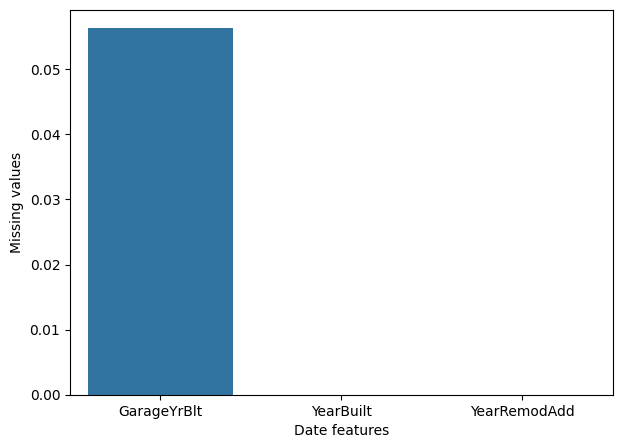

In [11]:
# Visualize missing values in our date variables
plt.figure(figsize=(7, 5))
sns.barplot(x=Date_V.index, y=Date_V.values)
plt.xlabel("Date features")
plt.ylabel("Missing values")
plt.show()

In [12]:
# Missing values in our numerical variables
Num_V = X_train[vars_num].isnull().mean().sort_values(ascending=False)
print(Num_V)
len(Num_V)

LotFrontage      0.177321
GarageYrBlt      0.056317
MasVnrArea       0.004566
MSSubClass       0.000000
OverallQual      0.000000
LotArea          0.000000
YearBuilt        0.000000
OverallCond      0.000000
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
YearRemodAdd     0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
FullBath         0.000000
TotalBsmtSF      0.000000
HalfBath         0.000000
BedroomAbvGr     0.000000
TotRmsAbvGrd     0.000000
KitchenAbvGr     0.000000
Fireplaces       0.000000
GarageCars       0.000000
GarageArea       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MiscVal          0.000000
MoSold           0.000000
YrSold           0.000000
dtype: float64


36

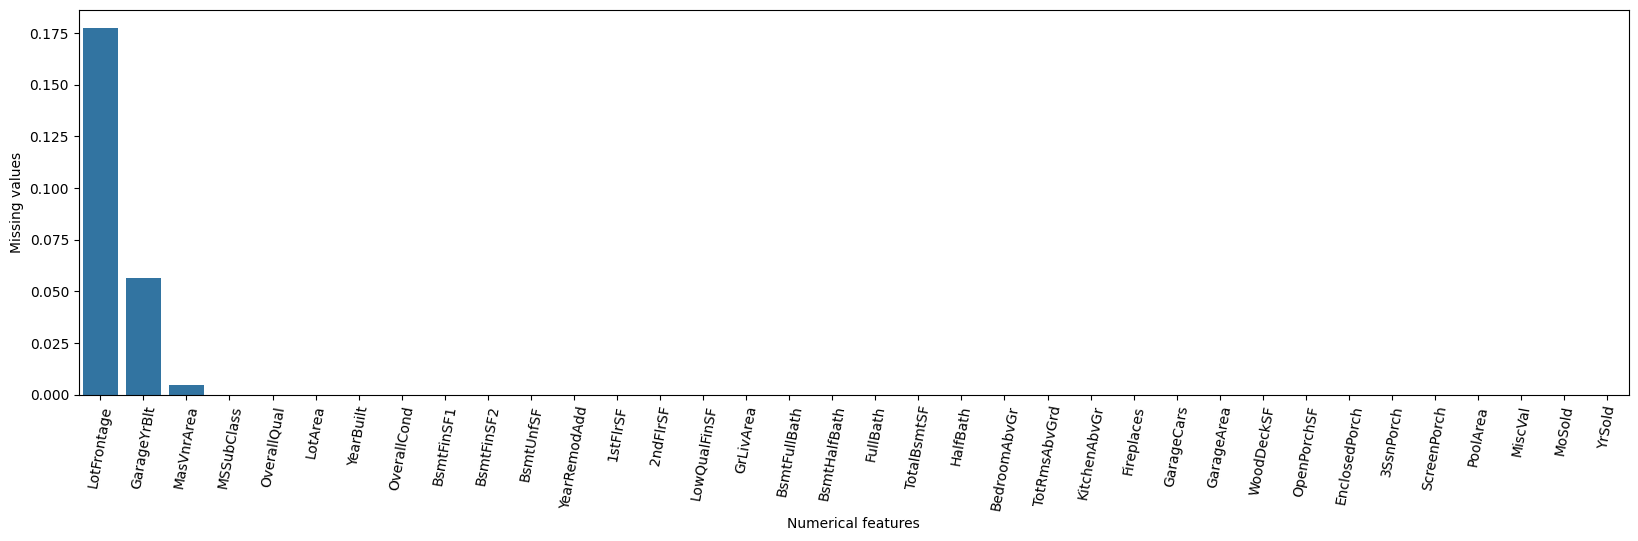

In [13]:
# Visualize missing values in our numerical variables
plt.figure(figsize=(20, 5))
sns.barplot(x=Num_V.index, y=Num_V.values)
plt.xlabel("Numerical features")
plt.ylabel("Missing values")
plt.xticks(rotation=80)
plt.show()

In [14]:
# Missing values in our categorical variables
Cat_V = X_train[vars_cat].isnull().mean().sort_values(ascending=False)
print(Cat_V)
len(Cat_V)

PoolQC           0.995434
MiscFeature      0.961187
Alley            0.938356
Fence            0.814307
MasVnrType       0.601218
FireplaceQu      0.472603
GarageFinish     0.056317
GarageQual       0.056317
GarageType       0.056317
GarageCond       0.056317
BsmtFinType2     0.025114
BsmtExposure     0.025114
BsmtFinType1     0.024353
BsmtQual         0.024353
BsmtCond         0.024353
Electrical       0.000761
Condition1       0.000000
Condition2       0.000000
LotShape         0.000000
Street           0.000000
MSZoning         0.000000
Neighborhood     0.000000
LandSlope        0.000000
LotConfig        0.000000
Utilities        0.000000
LandContour      0.000000
RoofStyle        0.000000
Heating          0.000000
ExterCond        0.000000
Foundation       0.000000
HouseStyle       0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
ExterQual        0.000000
BldgType         0.000000
HeatingQC        0.000000
CentralAir       0.000000
KitchenQual 

43

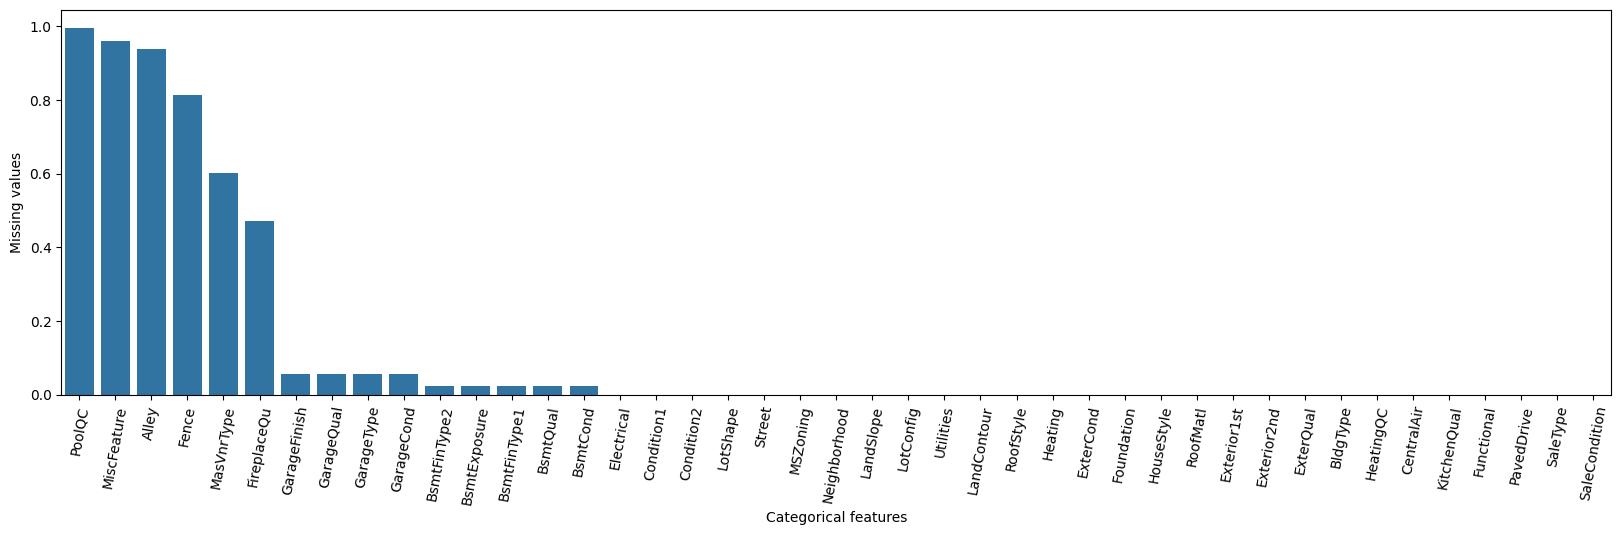

In [15]:
# Visualize missing values in our categorical variables
plt.figure(figsize=(20, 5))
sns.barplot(x=Cat_V.index, y=Cat_V.values)
plt.xlabel("Categorical features")
plt.ylabel("Missing values")
plt.xticks(rotation=80)
plt.show()

In [16]:
# Handling missing data through imputation
# Imputate numerical variables
imputer = SimpleImputer(strategy='constant', fill_value=-1) ##
X_train['LotFrontage'] = imputer.fit_transform(X_train['LotFrontage'].to_frame())
X_test['LotFrontage'] = imputer.transform(X_test['LotFrontage'].to_frame())

imputer = SimpleImputer(strategy='most_frequent')
X_train[vars_num] = imputer.fit_transform(X_train[vars_num])
X_test[vars_num] = imputer.transform(X_test[vars_num])

In [17]:
# Imputate categorical variables
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train[vars_cat] = imputer.fit_transform(X_train[vars_cat])
X_test[vars_cat] = imputer.transform(X_test[vars_cat])

In [18]:
# Temporal features
# Extracting information from the data to capture the difference in years between the year in which the house was built, and the year in which the house was sold.

In [19]:
# Create new temporal features from date variables
def elapsed_years(df, var):
    # capture difference between year variable and year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [20]:
# Apply it to both train and test set
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [21]:
# Check that test set does not contain null values in the engineered variables
[var for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'] if X_test[var].isnull().sum() > 0]

[]

In [22]:
############################## Checking for any Null still exists either in a train or test set##############################

In [23]:
# Train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [24]:
# Test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

In [25]:
# Replacing all rarely appearing categories with 'Rare':
# The RareLabelEncoder() groups rare or infrequent categories in a new category called “Rare”, or any other name entered by the user.

In [26]:
# Encode rare categories
rare_enc = RareLabelEncoder(tol=0.01,  n_categories=5, variables = vars_cat)
rare_enc.fit(X_train)
X_train = rare_enc.transform(X_train)
X_test = rare_enc.transform(X_test)

In [27]:
# Checking for rare categories
cat_dic = {}
for i in vars_cat:
    print(pd.DataFrame(X_train[vars_cat][i].value_counts() / 1460))

             count
MSZoning          
RL        0.709589
RM        0.134932
FV        0.037671
RH        0.010959
C (all)   0.006849
           count
Street          
Pave    0.896575
Grvl    0.003425
            count
Alley            
missing  0.844521
Grvl     0.030822
Pave     0.024658
             count
LotShape          
Reg       0.567808
IR1       0.301370
IR2       0.023973
IR3       0.006849
                count
LandContour          
Lvl          0.808904
Bnk          0.038356
HLS          0.029452
Low          0.023288
              count
Utilities          
AllPub     0.899315
NoSeWa     0.000685
              count
LotConfig          
Inside     0.656164
Corner     0.153425
CulDSac    0.058904
FR2        0.029452
FR3        0.002055
              count
LandSlope          
Gtl        0.848630
Mod        0.042466
Sev        0.008904
                 count
Neighborhood          
NAmes         0.137671
CollgCr       0.092466
OldTown       0.069863
Edwards       0.060274
Somer

In [28]:
# Encoding of Categorical variables
# Transform the string values of categorical variables into numerical values.

In [29]:
# Encode with labels
ordinal_enc = OrdinalEncoder_Sk()
X_train[vars_cat] = ordinal_enc.fit_transform(X_train[vars_cat])
X_test[vars_cat] = ordinal_enc.transform(X_test[vars_cat])

In [30]:
# Check any null values in test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

**Building Pipeline for Pre-Processing**:
* All the pre-processing steps above can be implemented inside Pre-Processing Pipeline. Building a pipeline removes the dual task of hard coding for the same operation on the train and test set separately. Apart from this, it helps in the automation of testing and deployment without much human intervention

**Creating Class** for temporal transformation that is compatible with SK_learn pipeline:
* In the pre-processing steps above, a function was created to calculate the year elapsed. Now we are converting that function into a class suitable for inserting inside the pipeline.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class TemporalVariableTransformer(BaseEstimator, TransformerMixin):
	# Temporal elapsed time transformer

    def __init__(self, variables, reference_variable):

        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables
        self.reference_variable = reference_variable

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):

    	# so that we do not over-write the original dataframe
        X = X.copy()

        for feature in self.variables:
            X[feature] = X[self.reference_variable] - X[feature]

        return X


In [32]:

vars_cat

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [33]:
# Building the Pre-Processing pipeline

price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute numerical variables with the ArbitraryNumberImputer
    ('ArbitraryNumber_imputation', ArbitraryNumberImputer( arbitrary_number=-1, variables='LotFrontage' )),

     # impute numerical variables with the mostfrequent
    ('frequentNumber_imputation', CategoricalImputer(imputation_method='frequent', variables=vars_num, ignore_format=True)),

    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(imputation_method='missing', variables=vars_cat)),

    # == TEMPORAL VARIABLES ====
    ('elapsed_time', TemporalVariableTransformer(
        variables=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], reference_variable='YrSold')),

    ('drop_features', DropFeatures(features_to_drop=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])),

      # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, variables=vars_cat)),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(encoding_method='ordered', variables=vars_cat)), #

])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), # predictors
                                                    data.SalePrice, # target
                                                    test_size=0.1,
                                                    random_state=0)  # for reproducibility
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1314, 80), (146, 80), (1314,), (146,))

In [35]:
price_pipe.fit(X_train,y_train) # Fitting

Pipeline(steps=[('ArbitraryNumber_imputation',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables='LotFrontage')),
                ('frequentNumber_imputation',
                 CategoricalImputer(ignore_format=True,
                                    imputation_method='frequent',
                                    variables=['MSSubClass', 'LotFrontage',
                                               'LotArea', 'OverallQual',
                                               'OverallCond', 'YearBuilt',
                                               'YearRemodAdd', 'MasVnrArea',
                                               'BsmtFinSF1', 'BsmtFinSF...
                                           'LotShape', 'LandContour',
                                           'Utilities', 'LotConfig',
                                           'LandSlope', 'Neighborhood',
                                           'Condition1', 'Condition2',
                                           'BldgType', 'HouseStyle',
                                           'RoofStyle', 'RoofMatl',
                                           'Exterior1st', 'Exterior2nd',
                                           'MasVnrType', 'ExterQual',
                                           'ExterCond', 'Foundation',
                                           'BsmtQual', 'BsmtCond',
                                           'BsmtExposure', 'BsmtFinType1',
                                           'BsmtFinType2', 'Heating',
                                           'HeatingQC', 'CentralAir',
                                           'Electrical', ...]))])

In [36]:
X_train_tfr=price_pipe.transform(X_train) # Transformation for train set

In [37]:
X_test_tfr=price_pipe.transform(X_test) # Transformation for test set

In [38]:
X_train_tfr

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
930,931,20,3,73.0,8925,1,2,1,3,1,1,0,19,3,1,4,4,8,5,0,0,9,9,1,0.0,2,3,4,3,3,3,6,16,4,0,1450,1466,2,4,1,3,1466,0,0,1466,0,0,2,0,3,1,2,7,4,0,1,4,3,3,610,2,3,2,100,18,0,0,0,0,0,4,3,0,7,2009,2,3
656,657,20,3,72.0,10007,1,2,1,1,1,1,0,8,3,1,4,4,5,7,0,0,4,5,2,54.0,2,3,2,2,3,1,4,806,4,0,247,1053,2,4,1,3,1053,0,0,1053,1,0,1,1,3,1,2,5,4,0,1,4,2,1,312,2,3,2,0,0,0,0,0,0,0,2,3,0,8,2008,2,3
45,46,120,3,61.0,7658,1,2,0,1,1,1,0,21,3,1,3,4,9,5,2,0,2,2,2,412.0,3,3,4,4,3,1,6,456,4,0,1296,1752,2,4,1,3,1752,0,0,1752,1,0,2,0,2,1,3,6,4,1,4,4,2,2,576,2,3,2,196,82,0,0,0,0,0,4,3,0,2,2010,2,3
1348,1349,20,3,-1.0,16196,1,2,2,2,1,1,0,10,3,1,4,4,7,5,0,0,9,9,1,0.0,2,3,4,3,3,4,6,1443,4,0,39,1482,2,4,1,3,1494,0,0,1494,1,0,2,0,3,1,2,5,4,1,2,4,2,2,514,2,3,2,402,25,0,0,0,0,0,4,3,0,8,2007,2,3
55,56,20,3,100.0,10175,1,2,1,1,1,1,0,8,3,1,4,4,6,5,0,0,4,6,2,272.0,1,3,2,2,3,1,2,490,4,0,935,1425,2,3,1,3,1425,0,0,1425,0,0,2,0,3,1,1,7,4,1,4,4,2,2,576,2,3,2,0,0,0,407,0,0,0,4,3,0,7,2008,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,764,60,3,82.0,9430,1,2,0,1,1,1,0,22,3,1,4,5,8,5,0,0,9,9,2,673.0,2,3,4,3,3,2,6,1163,4,0,89,1252,2,4,1,3,1268,1097,0,2365,1,0,2,1,3,1,2,8,4,1,4,4,2,3,856,2,3,2,0,128,0,0,180,0,0,4,3,0,7,2009,2,3
835,836,20,3,60.0,9600,1,2,0,1,1,1,0,6,3,1,4,4,4,7,0,0,9,5,1,0.0,1,3,2,3,3,1,2,442,4,0,625,1067,2,2,1,3,1067,0,0,1067,0,0,2,0,2,1,2,4,1,0,1,4,1,2,436,2,3,2,290,0,0,0,0,0,0,4,3,0,2,2010,2,3
1216,1217,90,1,68.0,8930,1,2,0,1,1,1,0,6,4,1,1,1,6,5,0,0,9,9,1,0.0,1,3,0,0,1,0,0,0,0,0,0,0,2,2,1,3,1318,584,0,1902,0,0,2,0,4,2,1,8,4,0,1,4,1,2,539,2,3,2,0,0,0,0,0,0,0,4,3,0,4,2010,2,3
559,560,120,3,-1.0,3196,1,2,0,1,1,1,0,14,3,1,3,4,7,5,0,0,9,9,2,18.0,2,3,4,3,3,4,5,0,4,0,1374,1374,2,4,1,3,1557,0,0,1557,0,0,2,0,2,1,2,7,4,1,3,4,3,2,420,2,3,2,143,20,0,0,0,0,0,4,3,0,10,2006,2,3


In [39]:
# XG-Boost Regressor
# Create an xgboost regression model

model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, objective='reg:squarederror', random_state=0)

#The most commonly configured hyperparameters for XgBoost are the following:

* n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
* max_depth: The maximum depth of each tree, often values are between 1 and 10.
* eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
* subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
* colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.


In [40]:
# Train on training set
model.fit(X_train_tfr, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [41]:
# Evaluate the model:
# Evaluate performance using the mean squared error and the root of the mean squared error
pred = model.predict(X_train_tfr)
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred))))
print()
pred = model.predict(X_test_tfr)
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred))))

linear train mse: 20771532.211054973
linear train rmse: 4557.579643961801

linear test mse: 881813785.5876962
linear test rmse: 29695.349561635005


Text(0.5, 1.0, 'Evaluation of XGBoost Predictions')

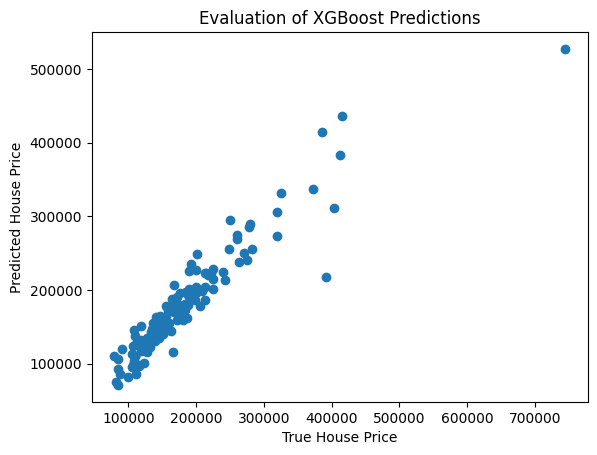

In [42]:
# Evaluating predictions with respect to the original price
plt.scatter(y_test, model.predict(X_test_tfr))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of XGBoost Predictions')

In [43]:
############### Displaying the feature importance value given by the XG-Boost model##############

In [44]:
# List features
print(X_train_tfr.columns.to_list())

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold

In [45]:
# Feature importance given by XGB
print(model.feature_importances_)

[6.43367646e-04 1.38582767e-03 2.00390234e-03 3.80904647e-03
 3.66741116e-03 0.00000000e+00 1.36570842e-03 6.40787138e-03
 5.10263443e-03 0.00000000e+00 6.93665817e-04 1.13549212e-03
 4.12668996e-02 3.69947334e-03 0.00000000e+00 2.63699540e-03
 2.46384926e-03 3.90457571e-01 3.46000399e-03 9.53414652e-04
 2.12325598e-03 2.25407700e-03 2.62254663e-03 1.12330157e-03
 6.25274749e-03 4.25541587e-02 1.66580162e-03 2.38634134e-03
 1.37143098e-02 2.74064811e-03 3.29134543e-03 2.96820467e-03
 9.95307788e-03 1.00376480e-03 1.82251912e-03 2.03875825e-03
 1.46721667e-02 3.75051779e-04 2.45141564e-03 1.20248040e-02
 2.40989705e-03 1.35458885e-02 7.96740595e-03 5.78837702e-04
 2.43222900e-02 5.50948875e-03 9.81089775e-04 1.43194376e-02
 6.54947665e-03 1.69190869e-03 1.07910286e-03 1.23194642e-02
 5.84967155e-03 3.06400307e-03 3.10189440e-03 1.21121649e-02
 4.53271857e-03 5.88971749e-03 2.17501163e-01 3.55288619e-03
 5.77554200e-03 2.39682570e-02 1.32516830e-03 2.92528863e-03
 2.14257697e-03 1.018592

In [46]:
# Feature Importance in dataframe
dfeature = pd.DataFrame({'Var': X_train_tfr.columns.to_list(),
                         'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
dfeature

,Var,Importance
17,OverallQual,0.390458
58,GarageCars,0.217501
25,ExterQual,0.042554
12,Neighborhood,0.041267
44,GrLivArea,0.024322
61,GarageCond,0.023968
36,TotalBsmtSF,0.014672
47,FullBath,0.014319
28,BsmtQual,0.013714
41,1stFlrSF,0.013546


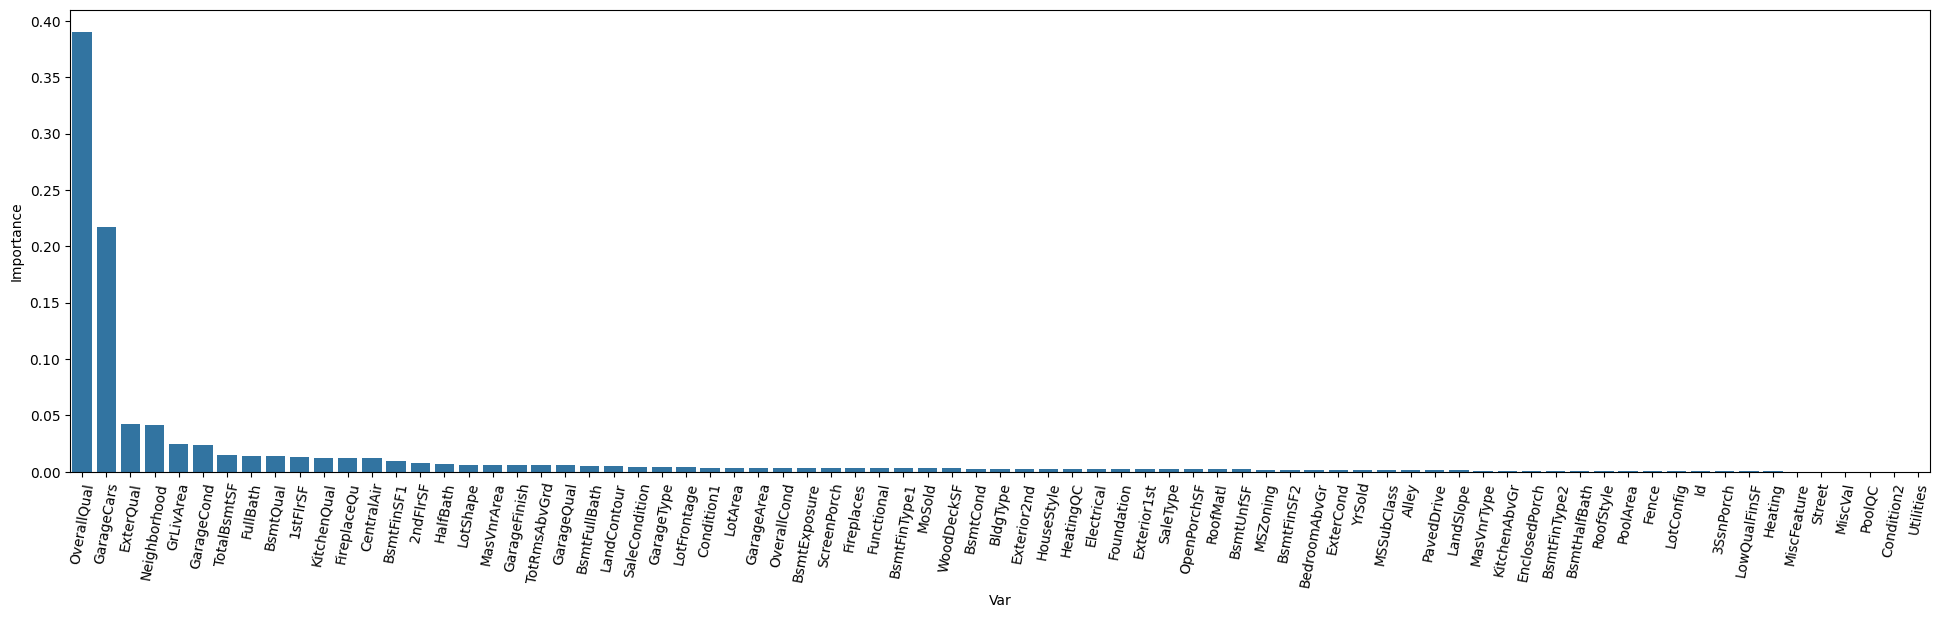

In [47]:
# Plot bar plot showing feature importances
plt.figure(figsize=(24, 6))
sns.barplot(x=dfeature['Var'], y=dfeature['Importance'])
plt.xticks(rotation=80)
plt.show()

In [48]:
# Top 15 features
dfeature[:16]['Var'].to_list()

['OverallQual',
 'GarageCars',
 'ExterQual',
 'Neighborhood',
 'GrLivArea',
 'GarageCond',
 'TotalBsmtSF',
 'FullBath',
 'BsmtQual',
 '1stFlrSF',
 'KitchenQual',
 'FireplaceQu',
 'CentralAir',
 'BsmtFinSF1',
 '2ndFlrSF',
 'HalfBath']

#Feature Selection:
* Above manual selection of best features can be done automatically using Scikit-Learn's SelectFromModel class. Here, we need to specify the model which has feature_importances_ or coef_ attribute after fitting, then train it.

In [49]:
######################### Feature selection using SelectFromModel, with XGBoost Regressor#########################

sel_ = SelectFromModel(xgb.XGBRegressor(n_estimators=150, objective='reg:squarederror', random_state=0))
sel_.fit(X_train_tfr, y_train)

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=150,
                                       n_jobs=None, num_parallel_tree=None,
                                       random_state=0, ...))

In [50]:
# Show the number of total features and selected features
selected_feat = X_train_tfr.columns[(sel_.get_support())]
print('total features: {}'.format((X_train_tfr.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 77
selected features: 10


In [51]:
selected_feat

Index(['Neighborhood', 'OverallQual', 'RoofMatl', 'BsmtQual', 'CentralAir',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'GarageCars'],
      dtype='object')

In [52]:
selected_feat

Index(['Neighborhood', 'OverallQual', 'RoofMatl', 'BsmtQual', 'CentralAir',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'GarageCars'],
      dtype='object')

In [53]:
# Re-build model with selected features
model.fit(X_train_tfr[selected_feat], y_train)

# Evaluate performance using the mean squared error and the root of the mean squared error
pred = model.predict(X_train_tfr[selected_feat])
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred))))
print()
pred = model.predict(X_test_tfr[selected_feat])
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred))))

linear train mse: 100636918.20565218
linear train rmse: 10031.795363027108

linear test mse: 1060672486.5434787
linear test rmse: 32567.967184696663


Text(0.5, 1.0, 'Evaluation of XGBoost Predictions')

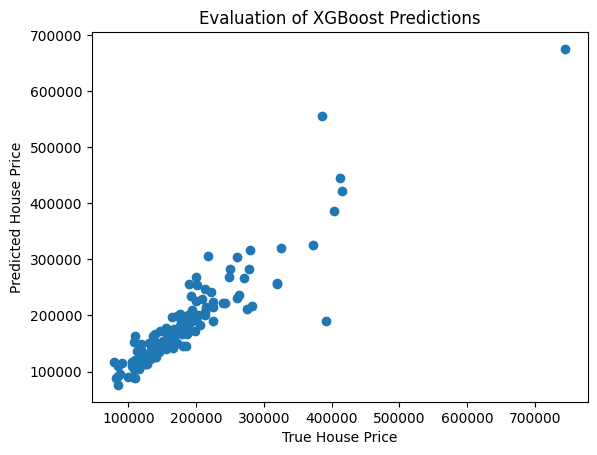

In [54]:
# Evaluating predictions with respect to the original price
plt.scatter(y_test, model.predict(X_test_tfr[selected_feat]))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of XGBoost Predictions')

#Training XGBoost without Pre-Processing:
* XGBoost can handle categorical variable and supports missing values by default. In tree algorithms, branch directions for missing values are learned during training.

**Note** that the gblinear booster treats missing values as zeros. When the missing parameter is specifed, values in the input predictor that is equal to missing will be treated as missing and removed. By default it’s set to NaN.Considering the same we are going to train without pre-processing and compare the result.

In [57]:
data_no_pro = pd.read_csv('/content/sample_data/train.csv')
print(data.shape)
data_no_pro.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [58]:
vars_cat = [var for var in X_train.columns if X_train[var].dtypes == 'O']

In [59]:
data_no_pro[vars_cat] = data_no_pro[vars_cat].apply(lambda x: x.astype('category'))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_no_pro.drop('SalePrice', axis=1), # predictors
                                                    data_no_pro.SalePrice, # target
                                                    test_size=0.1,
                                                    random_state=0)  # for reproducibility
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1314, 80), (146, 80), (1314,), (146,))

In [61]:
# Temporal features
# Extracting information from the data to capture the difference in years between the year in which the house was built, and the year in which the house was sold.

In [62]:
# Create new temporal features from date variables
def elapsed_years(df, var):
    # capture difference between year variable and year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [63]:
# Apply it to both train and test set
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [64]:
X_train=X_train.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])
X_test=X_test.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

In [65]:
# Modelling with unprocessed features

In [66]:
# Create an xgboost regression model
model_no_pro = xgb.XGBRegressor(n_estimators=100,max_depth=6, eta=0.1, subsample=0.7, colsample_bytree=0.8, objective='reg:squarederror', random_state=0, enable_categorical=True, tree_method='approx')

In [67]:
# Train on training set
model_no_pro.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [68]:
# Evaluate the model:
# Evaluate performance using the mean squared error and the root of the mean squared error
pred = model_no_pro.predict(X_train)
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred))))
print()
pred = model_no_pro.predict(X_test)
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred))))

linear train mse: 31727151.09738863
linear train rmse: 5632.685957639448

linear test mse: 903084252.1025174
linear test rmse: 30051.360237142635
